In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [5]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [6]:
import nltk
from nltk import ngrams
from nltk.corpus import stopwords

In [7]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
noise = stopwords.words('russian') + list(punctuation)

In [9]:
from collections import Counter

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
corpus = [token for tweet in df.text for token in nltk.tokenize.word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [12]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

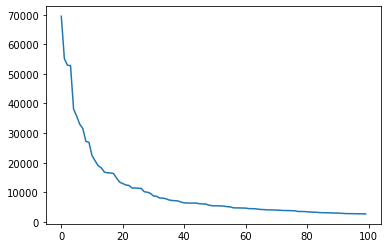

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [14]:
freq_df = pd.DataFrame(freq_dict_sorted, columns=['token', 'freq'])

In [15]:
high_freq_stop_words = list(freq_df[freq_df['freq'] < 1000]['token']) + noise
mid_freq_stop_words = list(freq_df[freq_df['freq'] >= 1000]['token']) + list(freq_df[freq_df['freq'] < 3]['token']) + noise
low_freq_stop_words = list(freq_df[freq_df['freq'] > 3]['token']) + noise

In [16]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, stop_words=high_freq_stop_words)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.62      0.68     33764
    positive       0.55      0.69      0.61     22945

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.64     56709
weighted avg       0.67      0.65      0.65     56709



In [17]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, stop_words=mid_freq_stop_words)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.78      0.74      0.76     29694
    positive       0.73      0.77      0.75     27015

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.76      0.75      0.75     56709



In [18]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, stop_words=low_freq_stop_words)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.84      0.57      0.68     41049
    positive       0.39      0.71      0.50     15660

    accuracy                           0.61     56709
   macro avg       0.61      0.64      0.59     56709
weighted avg       0.71      0.61      0.63     56709



При заданных часто(больше 1000), средне(от 3 до 1000) и редко (меньше 3) лучшая точность на токенах со средней частотой.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [19]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28061
    positive       1.00      1.00      1.00     28648

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [20]:
ind = np.argsort(clf.coef_[0])
ind = ind[-10:]

In [21]:
for i in ind:
    print(vec.get_feature_names()[i],'- score:', clf.coef_[0][i]) 

ddddd - score: 3.26943992131017
dddd - score: 4.668924731977022
: - score: 5.956196709608102
* - score: 7.123792757417957
-d - score: 7.317683379654399
ddd - score: 8.015034034288698
^_^ - score: 9.320408986603933
dd - score: 10.514304006371455
d - score: 26.72113377729245
) - score: 58.42088315866768


Фича ')' с самым большим коэффициэнтом

Остальные знаки пунктуации:

In [22]:
ind = list()
symbols = list(punctuation)
for symbol in symbols:
    if symbol in vec.vocabulary_.keys():
        ind.append(vec.vocabulary_[symbol])

for i in ind:
    print(vec.get_feature_names()[i],'- score:', clf.coef_[0][i]) 

! - score: 0.11721831455368074
# - score: 0.47177266760483805
$ - score: -0.0537817378688202
% - score: 1.2618898641459064
& - score: -0.37855437122273455
' - score: -0.018231828918434608
( - score: -59.70401392892213
) - score: 58.42088315866768
* - score: 7.123792757417957
+ - score: -0.04084627857065197
, - score: 0.9171394682745307
- - score: -0.6244888192125696
. - score: -0.7437234941409201
/ - score: 0.5266580380698742
: - score: 5.956196709608102
; - score: 0.28334203879730974
= - score: 0.3926584927374377
? - score: -0.513382477973666
@ - score: -1.3165814042590789
[ - score: 0.07257727532540084
\ - score: -0.00012320835540970715
] - score: 0.12954931895802918
^ - score: -0.11821264755753329
_ - score: -1.6454825496897838
` - score: -0.1476338913441438
{ - score: 0.0008132925136072058
| - score: -11.053451548987212
} - score: -0.02085799882705687
~ - score: -0.4062843153674901


Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [23]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     33055
    positive       0.83      1.00      0.91     23654

    accuracy                           0.91     56709
   macro avg       0.91      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [24]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.78     29109
    positive       0.76      0.79      0.78     27600

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [25]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=nltk.tokenize.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.78      0.77     27684
    positive       0.78      0.77      0.78     29025

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [26]:
vec = HashingVectorizer(n_features=150000, tokenizer=nltk.tokenize.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     28172
    positive       0.76      0.77      0.76     28537

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Третье задание полностью не успел сделать... Из трех моделей CountVectorizer работает немного лучше остальных.